In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt

# reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
gex_path = "/Users/dana/Desktop/AHI/01_PAML/Project/data/mammacarcinoma_gex.csv"
pat_path = "/Users/dana/Desktop/AHI/01_PAML/Project/data/mammacarcinoma_pat.csv"


# load raw data
gex = pd.read_csv(gex_path, index_col=0)
patinfo = pd.read_csv(pat_path)

In [4]:
# merge
data = patinfo.merge(gex, on="patient_id")

# define target
target_col = "er"

# remove samples with missing target
data = data[data[target_col].notna()].copy()

# ensure binary integer target
y = data[target_col].astype(int)

# metadata columns
meta_cols = ["node", "grade", "size", "age", "relapse"]

# gene columns
gene_cols = [c for c in data.columns if c not in meta_cols + ["patient_id", target_col]]

# split data
X_train, X_val, y_train, y_val = train_test_split(
    data,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_SEED)

# impute metadata using training means only
meta_means = X_train[meta_cols].mean()

for df in [X_train, X_val]:
    df[meta_cols] = df[meta_cols].fillna(meta_means)

In [5]:
# feature sets
# all genes + metadata
X_train_all = X_train[gene_cols + meta_cols]
X_val_all   = X_val[gene_cols + meta_cols]

# llm-selected genes
llm_genes = ['ESR1',
'PGR',
'GATA3',
'XBP1',
'TFF1',
'MKI67',
'CCNB1',
'ERBB2',
'EGFR',
'VIM',
'CDH1',
'FOXC1',
'KRT5',
'KRT14',
'MAPT',
'NAT1']

X_train_llm = X_train[llm_genes + meta_cols]
X_val_llm   = X_val[llm_genes + meta_cols]

In [6]:
# pca feature set (genes only)

scaler_gene = StandardScaler()
X_train_gene_scaled = scaler_gene.fit_transform(X_train[gene_cols])
X_val_gene_scaled   = scaler_gene.transform(X_val[gene_cols])

pca = PCA(n_components=8, random_state=RANDOM_SEED)
X_train_pca = pca.fit_transform(X_train_gene_scaled)
X_val_pca   = pca.transform(X_val_gene_scaled)

# scale metadata separately
scaler_meta = StandardScaler()
X_train_meta_scaled = scaler_meta.fit_transform(X_train[meta_cols])
X_val_meta_scaled   = scaler_meta.transform(X_val[meta_cols])

# concatenate
X_train_pca_final = np.hstack([X_train_pca, X_train_meta_scaled])
X_val_pca_final   = np.hstack([X_val_pca, X_val_meta_scaled])

In [7]:
# evaluation function

def evaluate_model(X, y, model):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    accs, f1s, rocs = [], [], []

    for tr_idx, va_idx in cv.split(X, y):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_va)
        y_prob = model.predict_proba(X_va)[:, 1]

        accs.append(accuracy_score(y_va, y_pred))
        f1s.append(f1_score(y_va, y_pred))
        rocs.append(roc_auc_score(y_va, y_prob))

    return {
        "accuracy": np.mean(accs),
        "f1": np.mean(f1s),
        "roc_auc": np.mean(rocs)
    }

In [8]:
# models
lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=RANDOM_SEED)

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=RANDOM_SEED)

In [9]:
# run comparison

results = []

results.append({
    "feature_set": "all_features",
    "model": "logistic_regression",
    **evaluate_model(X_train_all, y_train, lr)})

results.append({
    "feature_set": "llm_genes",
    "model": "logistic_regression",
    **evaluate_model(X_train_llm, y_train, lr)})

results.append({
    "feature_set": "pca_features",
    "model": "logistic_regression",
    **evaluate_model(pd.DataFrame(X_train_pca_final), y_train, lr)})

results.append({
    "feature_set": "all_features",
    "model": "random_forest",
    **evaluate_model(X_train_all, y_train, rf)})

results.append({
    "feature_set": "llm_genes",
    "model": "random_forest",
    **evaluate_model(X_train_llm, y_train, rf)})

results.append({
    "feature_set": "pca_features",
    "model": "random_forest",
    **evaluate_model(pd.DataFrame(X_train_pca_final), y_train, rf)})

results_df = pd.DataFrame(results)
print(results_df.sort_values("roc_auc", ascending=False))


    feature_set                model  accuracy        f1   roc_auc
3  all_features        random_forest  0.865959  0.926924  0.940377
0  all_features  logistic_regression  0.919102  0.953888  0.939568
1     llm_genes  logistic_regression  0.870122  0.920106  0.939000
4     llm_genes        random_forest  0.906612  0.946318  0.921710
2  pca_features  logistic_regression  0.870286  0.922585  0.919995
5  pca_features        random_forest  0.914857  0.951945  0.912628


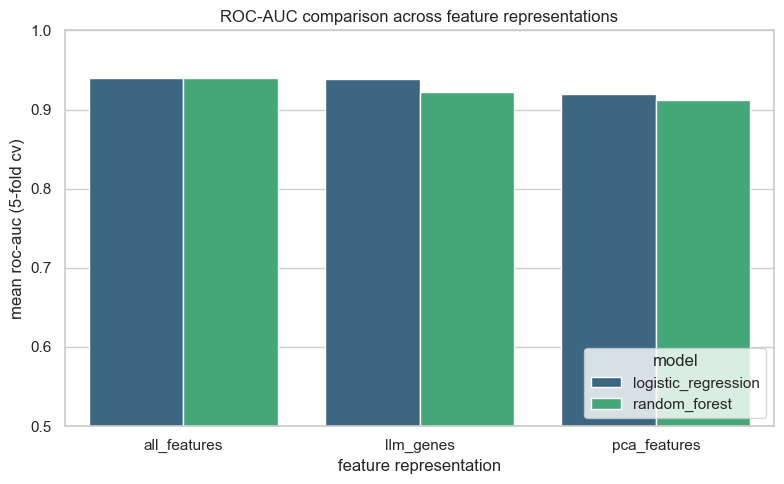

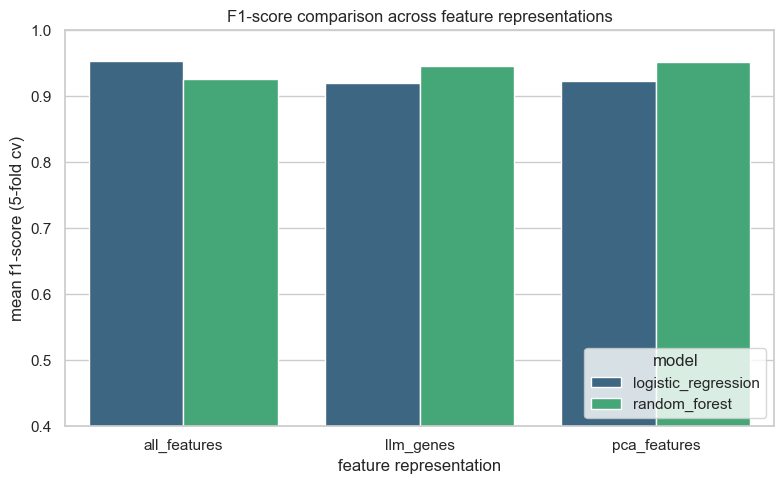

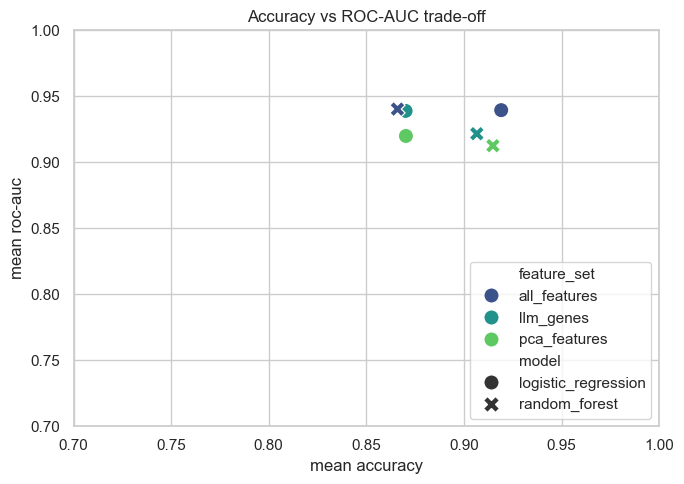

In [10]:
sns.set(style="whitegrid")


# bar plot: roc-auc comparison

plt.figure(figsize=(8, 5))
sns.barplot(
    data=results_df,
    x="feature_set",
    y="roc_auc",
    hue="model",
    palette="viridis")

plt.title("ROC-AUC comparison across feature representations")
plt.ylabel("mean roc-auc (5-fold cv)")
plt.xlabel("feature representation")
plt.ylim(0.5, 1.0)
plt.legend(title="model", loc="lower right")
plt.tight_layout()
plt.savefig("ROC-AUC_comparison.png", dpi=300)
plt.show()


# bar plot: f1-score comparison


plt.figure(figsize=(8, 5))
sns.barplot(
    data=results_df,
    x="feature_set",
    y="f1",
    hue="model",
    palette="viridis")

plt.title("F1-score comparison across feature representations")
plt.ylabel("mean f1-score (5-fold cv)")
plt.xlabel("feature representation")
plt.ylim(0.4, 1.0)
plt.legend(title="model", loc="lower right")
plt.tight_layout()
plt.savefig("F1-score_comparison.png", dpi=300)
plt.show()


# accuracy vs roc-auc scatter

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=results_df,
    x="accuracy",
    y="roc_auc",
    hue="feature_set",
    style="model",
    palette="viridis",
    s=120)

plt.title("Accuracy vs ROC-AUC trade-off")
plt.xlabel("mean accuracy")
plt.ylabel("mean roc-auc")
plt.xlim(0.7, 1.0)
plt.ylim(0.7, 1.0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("Accuracy_vs_ROC-AUC.png", dpi=300)
plt.show()